# Compare different q0cuts - run 6341



In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Tue Nov 27 13:04:54 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
import collections       as collections
import pandas            as pd

from   scipy import optimize
import invisible_cities.core.fit_functions as fitf
from  invisible_cities.core .core_functions import in_range

import krcal.utils.plt_functions          as krplot
import krcal.utils.hst_extend_functions   as hst

import csth.utils.cepeak_plot             as cpkplot

In [4]:
# Plotting style
default_cmap = "jet"
figure_size  = 14, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

## load files

In [5]:
run_number = 6341
trigger    = 'trigger2'
#input_filename = f"$IC_DATA/{run_number}/pmaps/cepks_{run_number}_90_9188_{trigger}.h5"
tags = ['1', '3', '6', '9', '12', '18', '24', '30']
input_filenames = [f"$IC_DATA/{run_number}/cepks/cepks_{run_number}_0000_11999_{tag}q0min.h5" for tag in tags]
input_files     = [os.path.expandvars(ifile) for ifile in input_filenames]

In [6]:
def esum_from_hdf(filename, clear = True):
    print(filename)
    h = pd.HDFStore(filename)
    esum = h['esum']
    print('total events :', len(esum))
    esum.dropna()
    sel_base = (esum.nslices > 0) & (esum.nhits > 0) & (esum.zmax < 650.) & (esum.s1e >0)
    esum = esum[sel_base]
    print('clean events :', len(esum) )
    #esum0 = esum[sel_base]
    #h.close()
    return esum

In [7]:
esums = [esum_from_hdf(ifile) for ifile in input_files]

/Users/hernando/investigacion/NEXT/data/runIV//6341/cepks/cepks_6341_0000_11999_1q0min.h5
total events : 203955
clean events : 199447
/Users/hernando/investigacion/NEXT/data/runIV//6341/cepks/cepks_6341_0000_11999_3q0min.h5
total events : 203821
clean events : 199335
/Users/hernando/investigacion/NEXT/data/runIV//6341/cepks/cepks_6341_0000_11999_6q0min.h5
total events : 203104
clean events : 198732
/Users/hernando/investigacion/NEXT/data/runIV//6341/cepks/cepks_6341_0000_11999_9q0min.h5
total events : 202239
clean events : 197953
/Users/hernando/investigacion/NEXT/data/runIV//6341/cepks/cepks_6341_0000_11999_12q0min.h5
total events : 200672
clean events : 196530
/Users/hernando/investigacion/NEXT/data/runIV//6341/cepks/cepks_6341_0000_11999_18q0min.h5
total events : 196196
clean events : 192511
/Users/hernando/investigacion/NEXT/data/runIV//6341/cepks/cepks_6341_0000_11999_24q0min.h5
total events : 192008
clean events : 188748
/Users/hernando/investigacion/NEXT/data/runIV//6341/cepks/c

In [8]:
#cpkplot.df(esum)

## Total energy

In [9]:
Ea = hst.Vaxis((0., 700e3), 500)
def canvas_e(esums, i0):
    alpha = 1./len(esums)
    #c = hst.Canvas(1, 1)
    for i, esum in enumerate(esums):
        plt.hist(esum.e, Ea.bins, alpha = alpha, label= tags[i0+i]) 
        plt.xlabel('E (pes)')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()

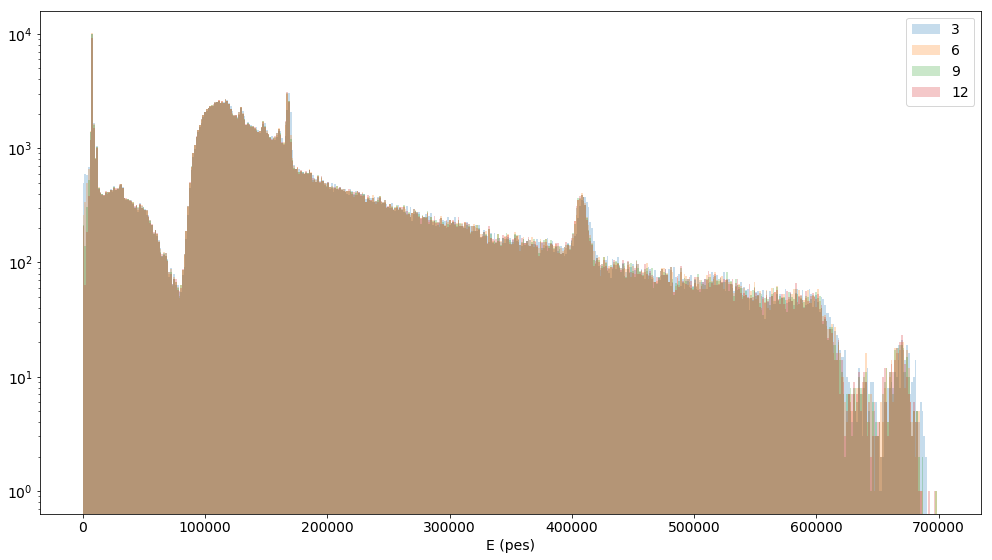

In [10]:
canvas_e(esums[1:5], 1)

In [11]:
Exra = hst.Vaxis((  5e3,  10e3), 100)
Ecsa = hst.Vaxis((110e3, 190e3), 100)
Edsa = hst.Vaxis((350e3, 450e3), 100)
Etha = hst.Vaxis((500e3, 700e3), 100)
def canvas_eregions(esums, i0):
    alpha = 1./len(esums)
    c = hst.Canvas(2, 2)
    for i, esum in enumerate(esums):
        hst.hist(esum.e, Exra.bins, alpha = alpha, stats = None, canvas = c(1), label = tags[i + i0], xylabels=('E (pes)',''))
        hst.hist(esum.e, Ecsa.bins, alpha = alpha, stats = None, canvas = c(2), label = tags[i + i0], xylabels=('E (pes)',''))
        hst.hist(esum.e, Edsa.bins, alpha = alpha, stats = None, canvas = c(3), label = tags[i + i0], xylabels=('E (pes)',''))
        hst.hist(esum.e, Etha.bins, alpha = alpha, stats = None, canvas = c(4), label = tags[i + i0], xylabels=('E (pes)',''))
    plt.legend()
    plt.tight_layout()

## Eenrgy in regions

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


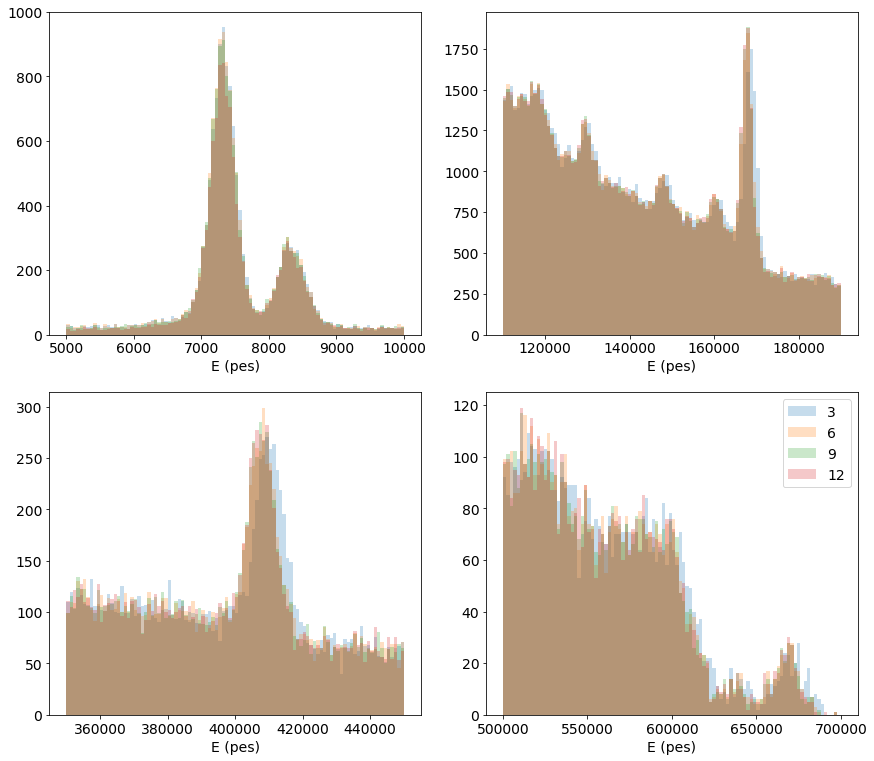

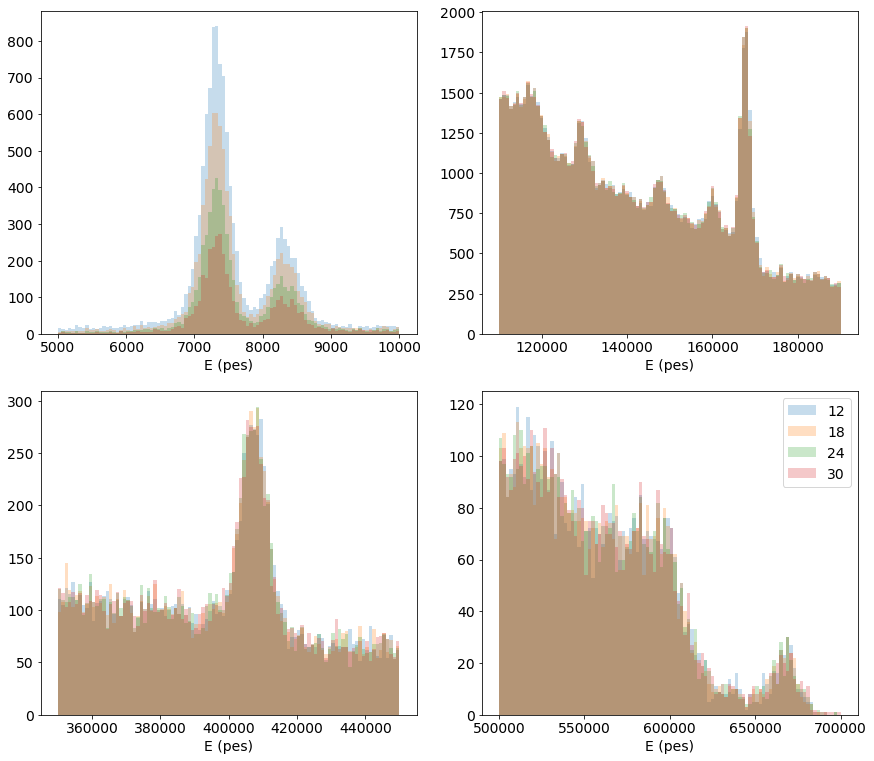

In [12]:
canvas_eregions(esums[1:5], 1)
canvas_eregions(esums[4:],  4)

## Fits in regions for different cuts

In [13]:
import csth.utils.fits as efit

def plot_extll_fit(es, e0, e1, mushat, nbins = 100, alpha = 0.5, tag = ''):
    pg = efit.Pol1DGaus(a = e0, b = e1, shapes = 'mu, sigma, mslope, f')
    mu, sigma, mslope, nug, nup = mushat[0], mushat[1], mushat[2], mushat[3], mushat[4]
    ntot = nug + nup
    f = float(nug)/float(nug+nup)
    pf = efit.Pol1DGaus(a = e0, b = e1, shapes = 'mu, sigma, mslope, f')
    xs = np.linspace(e0, e1, nbins)
    dx = xs[1]-xs[0]
    ys = ntot * dx * pg.pdf(xs, mu = mu, sigma = sigma, mslope = mslope, f = f)
    plt.hist(es, nbins, range = (e0, e1), alpha = alpha)
    fwhm = 235.* sigma/mu
    label = tag + ' n = ' + str(int(nug)) + ', $\mu$ = ' + "{0:.0f}".format(mu) + ', FWHM (%) = ' + "{0:.2f}".format(fwhm)
    plt.plot(xs, ys, ls= '-', lw = 2, label = label, alpha = alpha)
    plt.xlim(e0, e1)
    plt.legend()
    return (xs, ys)
    

In [14]:
def canvas_esigma(esum, erange, nbins= 100, tag='', alpha = 0.5):
    e0, e1 = erange
    dssel = in_range(esum.e, e0, e1)
    es = esum.e[dssel]
    mushat = efit.extll_fit_pol1dgaus(es, e0, e1)
    print(es.min(), es.max())
    #plt.hist(es, nbins, range = (360e3, 440e3))
    #plt.xlim(e0, e1)
    dat = plot_extll_fit(es, e0, e1, mushat, tag = tag, alpha = alpha)
    return mushat, dat

360000.0162875035 439999.9554674435
360002.267632499 439995.3545468465
360004.70676981204 439958.832615509
360002.16598891123 439992.0929523663


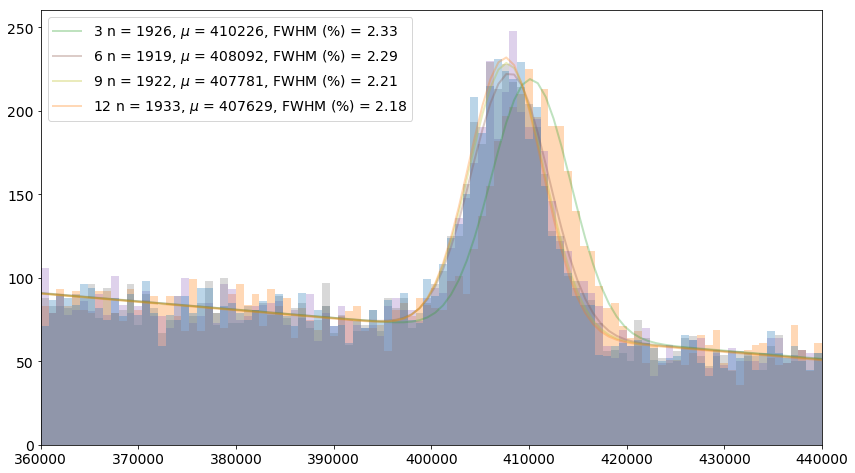

In [15]:
i0 = 1
for i, esum in enumerate(esums[1:5]):
    tag = tags[i0 + i]
    canvas_esigma(esum, (360e3, 440e3), tag = tag, alpha = 0.3);
    

360002.16598891123 439992.0929523663
360003.87718596024 439986.77150464326
360002.37292963266 439980.048620263
360006.60282207234 439990.2242134251


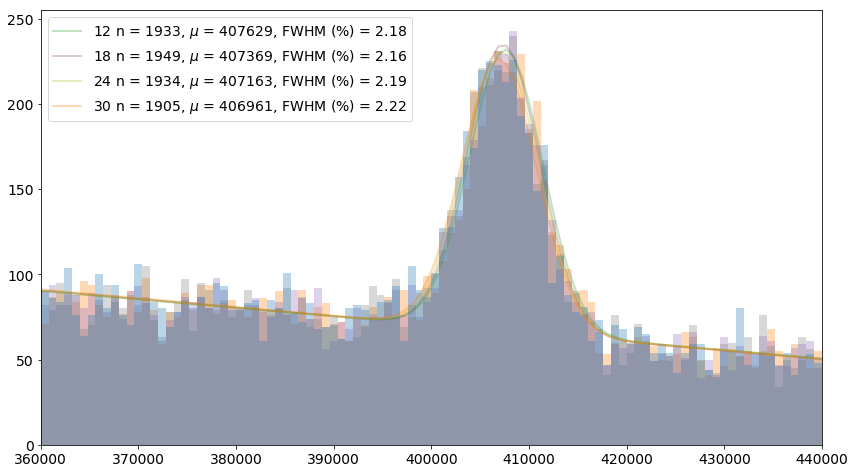

In [16]:
i0 = 4
for i, esum in enumerate(esums[4::]):
    tag = tags[i0 + i]
    canvas_esigma(esum, (360e3, 440e3), tag = tag, alpha = 0.3);

160000.8389360353 174996.97680605814
160000.3125939338 174999.4596252455
160000.61503528486 174995.86457108188
160000.77513171814 174996.9122681293


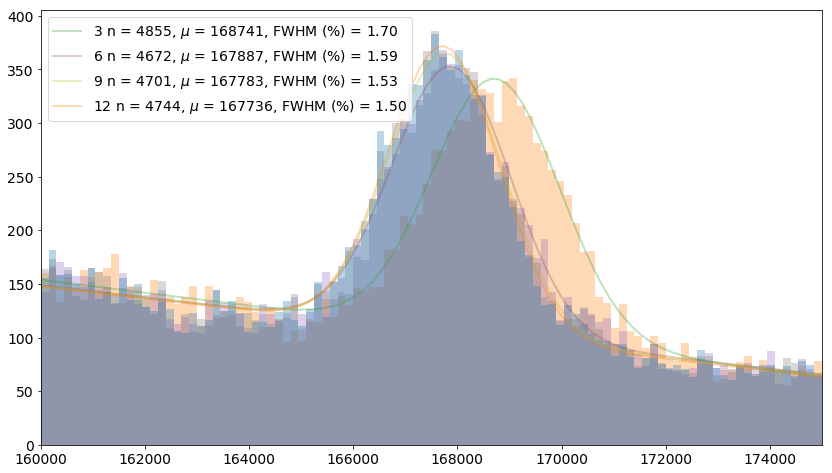

In [17]:
i0 = 1
for i, esum in enumerate(esums[1:5]):
    tag = tags[i0 + i]
    canvas_esigma(esum, (160e3, 175e3), tag = tag, alpha = 0.3);
    

160000.77513171814 174996.9122681293
160001.26616559294 174999.48192025244
160000.35960965022 174998.79385426664
160000.00130932522 174999.91839646586


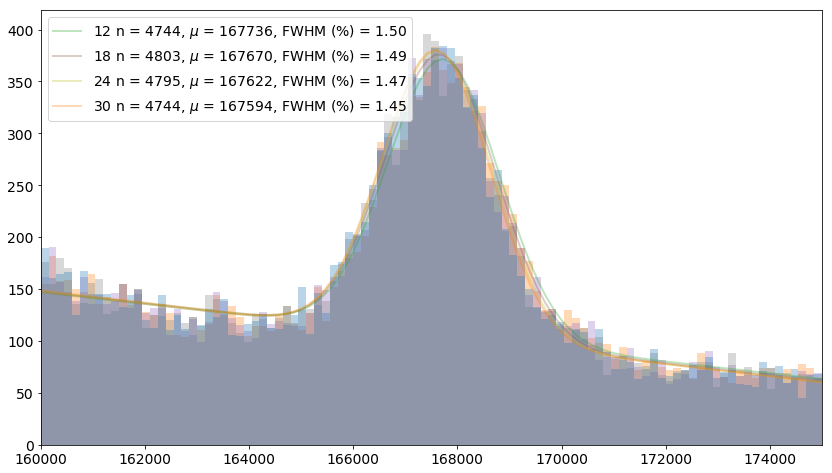

In [18]:
i0 = 4
for i, esum in enumerate(esums[4:]):
    tag = tags[i0 + i]
    canvas_esigma(esum, (160e3, 175e3), tag = tag, alpha = 0.3);
    

6500.043369131165 7799.714740469752
6502.124596998843 7799.566567699607
6503.4330022112335 7799.588058022658
6503.036733506546 7799.330900386972


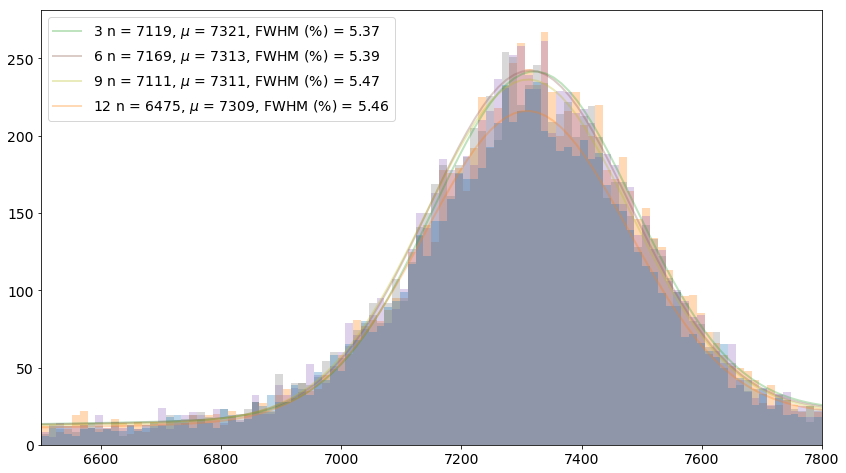

In [19]:
i0 = 1
for i, esum in enumerate(esums[1:5]):
    tag = tags[i0 + i]
    canvas_esigma(esum, (6.5e3, 7.8e3), tag = tag, alpha = 0.3);

6503.036733506546 7799.330900386972
6502.644886677496 7799.860391864974
6502.644886677496 7798.826067685789
6501.949913151542 7798.246007703692


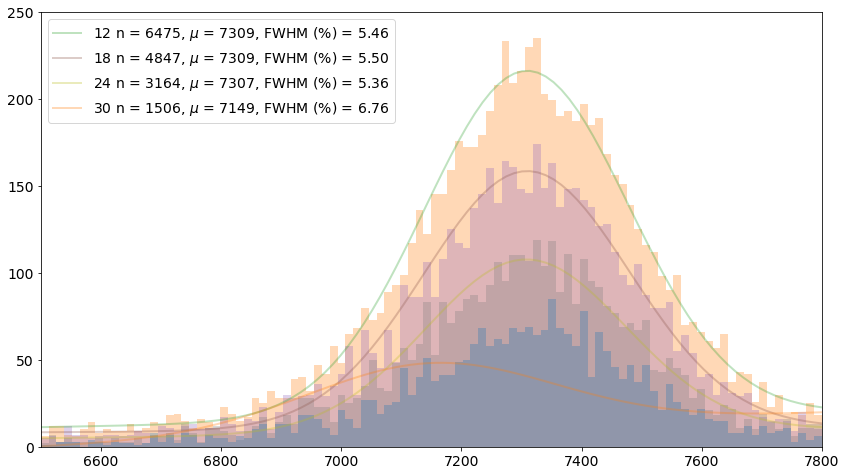

In [20]:
i0 = 4
for i, esum in enumerate(esums[4:]):
    tag = tags[i0 + i]
    canvas_esigma(esum, (6.5e3, 7.8e3), tag = tag, alpha = 0.3);

650060.2000800304 689850.7147701879
650070.8190508259 697992.548247833
650585.1767214405 697525.7866421791
650467.7783427965 697039.9116288339


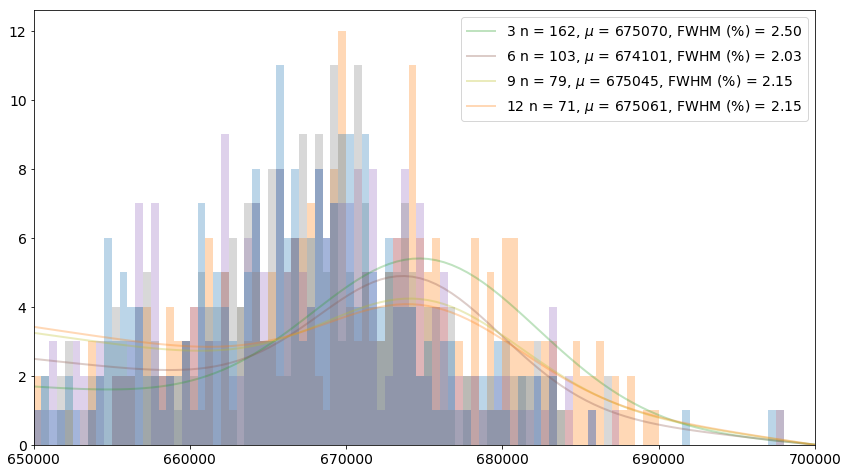

In [21]:
i0 = 1
for i, esum in enumerate(esums[1:5]):
    tag = tags[i0 + i]
    canvas_esigma(esum, (650e3, 700e3), tag = tag, alpha = 0.3);

650467.7783427965 697039.9116288339
650395.8623508081 696561.9489846368
650070.6332235355 696656.0947497785
650471.8028820949 699955.6804067844


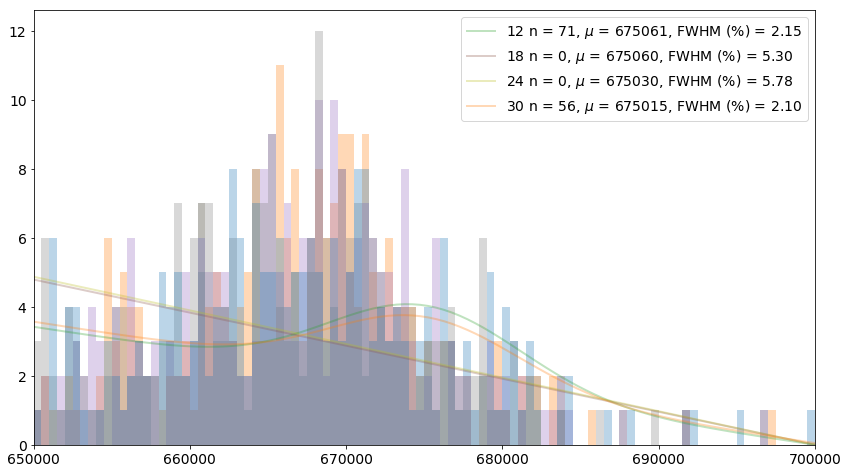

In [22]:
i0 = 4
for i, esum in enumerate(esums[4:]):
    tag = tags[i0 + i]
    canvas_esigma(esum, (650e3, 700e3), tag = tag, alpha = 0.3);

## Studying some events

In [23]:
esum0 = esums[2]

### Double Scape peak

In [31]:
xsel = in_range(esum0.e, 407.5e3, 407.6e3)

In [32]:
np.sum(xsel)

23

In [33]:
dsesum = esum0[xsel]

In [34]:
dsesum

,event,peak,location,nslices,nhits,noqslices,time,s1e,t0,rmax,...,x1,y1,z1,e2,x2,y2,z2,eblob1,eblob2,d12
10,161821,0,491,52,683,4,1537695549871,384.355774,508.592334,208.925824,...,65.0,25.0,182.903259,1408.480850,75.0,5.0,179.929260,9185.991336,9619.672300,22.557586
1,225027,0,684,37,1010,3,1537697053917,440.636261,347.811012,207.966343,...,-175.0,-85.0,311.671478,986.885129,-175.0,-85.0,327.676910,19762.463406,1979.846407,16.005432
25,237420,0,721,61,935,5,1537697348309,444.526520,359.578565,209.880919,...,-45.0,175.0,304.924194,732.304633,-45.0,165.0,321.909729,18962.061484,3794.092128,19.710616
15,444298,0,1351,60,775,4,1537702275015,399.015076,473.002319,190.394328,...,-135.0,65.0,182.494629,1231.535577,-115.0,125.0,226.502197,14054.725045,7500.554601,77.049763
1,459209,0,1398,71,856,3,1537702631029,445.513062,372.860036,186.681547,...,-75.0,135.0,296.615723,991.976576,-35.0,105.0,293.598755,9993.127099,8137.290700,50.090938
10,470017,0,1430,78,937,5,1537702888177,460.130981,332.454832,136.565003,...,-15.0,55.0,326.021057,391.583550,-5.0,25.0,328.980957,16422.995413,4533.180095,31.760998
14,547600,0,1666,36,676,2,1537704743999,342.280609,572.459189,171.026314,...,-125.0,75.0,79.152222,1315.282580,-125.0,65.0,93.053894,13557.611146,3413.032863,17.124734
7,548251,0,1669,57,919,3,1537704759420,382.341217,539.043783,226.384628,...,45.0,115.0,129.408875,1419.974891,35.0,155.0,128.433777,6067.940613,5356.234801,41.242585
14,746892,0,2274,60,903,4,1537709497450,415.353027,430.758926,142.302495,...,25.0,105.0,251.736572,776.987876,25.0,125.0,247.775574,14358.192753,3650.743928,20.388465
9,839311,0,2557,60,880,4,1537711702791,425.536407,426.079830,187.216452,...,-155.0,75.0,248.409912,1015.526654,-145.0,55.0,251.394043,15975.394629,4551.856753,22.558924


In [36]:
events = dsesum.event
locs   = dsesum.location

In [38]:
print('events: ', events.values)
print('locats: ', locs.values)

events:  [ 161821  225027  237420  444298  459209  470017  547600  548251  746892
  839311 1179868 1237945 1551968 1715200 1784431 2144002 2614906 2950511
 3488083 3544274 3630533 3745598 3773679]
locats:  [  491   684   721  1351  1398  1430  1666  1669  2274  2557  3599  3779
  4740  5242  5457  6563  8017  9061 10730 10900 11173 11526 11618]


### Th Photo-peak

In [41]:
xsel = in_range(esum0.e, 669.e3, 671.e3)
print(np.sum(xsel))
tlesum = esum0[xsel]
tlesum

29


,event,peak,location,nslices,nhits,noqslices,time,s1e,t0,rmax,...,x1,y1,z1,e2,x2,y2,z2,eblob1,eblob2,d12
7,172701,0,524,98,1648,6,1537695808493,686.899597,418.929720,145.773797,...,-45.0,85.0,301.554413,1245.482481,-55.0,125.0,303.547943,20309.453059,5249.537019,41.279222
4,484154,0,1473,94,1581,3,1537703225385,534.611511,625.822544,225.055549,...,-15.0,-65.0,89.676575,1072.803092,-15.0,-75.0,102.658875,28853.276756,2272.368019,16.387194
4,701190,0,2135,90,1809,4,1537708406321,714.375000,418.516684,161.400124,...,-75.0,-25.0,310.016205,822.319248,-65.0,-35.0,317.854645,23535.517135,6208.566520,16.169142
19,797288,0,2428,83,1423,2,1537710701531,559.387573,580.804951,227.705951,...,-195.0,-55.0,128.694336,1562.042934,-175.0,-35.0,130.701660,14398.465192,10716.626072,28.355411
0,831505,0,2534,75,1436,6,1537711515859,662.867249,455.845216,195.064092,...,-15.0,-25.0,254.689697,2098.979376,5.0,5.0,256.656250,23382.772526,13037.989952,36.109103
8,975845,0,2975,73,1301,2,1537714949260,568.501404,609.732236,216.448608,...,-45.0,165.0,67.771423,1814.328346,-55.0,185.0,67.771423,19256.162834,6117.574269,22.360680
8,978755,0,2984,84,1454,3,1537715018852,687.857422,439.446371,178.465683,...,-155.0,-15.0,222.056122,659.654663,-145.0,-25.0,214.068329,34052.718373,2876.138127,16.242070
10,1318857,0,4027,77,1642,3,1537723111264,703.528015,385.137982,212.720474,...,-85.0,155.0,291.352325,1430.335120,-105.0,155.0,296.333771,22292.119494,7811.571956,20.611036
25,1324558,0,4043,95,1580,6,1537723247485,824.121155,271.788757,186.681547,...,-85.0,-115.0,379.760071,1674.241373,-95.0,-95.0,383.702698,16770.954940,13392.133602,22.705601
4,1567821,0,4791,103,1205,2,1537729039870,17.328257,228.444822,221.472346,...,-105.0,125.0,435.063354,1517.277557,55.0,-185.0,498.021423,7002.237972,10766.062777,354.490788


In [44]:
events = tlesum.event.values
locs   = tlesum.location.values

In [45]:
events

array([ 172701,  484154,  701190,  797288,  831505,  975845,  978755,
       1318857, 1324558, 1567821, 1723812, 1724205, 1820805, 1902262,
       1924001, 1926053, 2352509, 2394401, 2424537, 2520837, 2554716,
       2671606, 2759684, 2811370, 3308282, 3652165, 3758692, 3775456,
       3780397])

In [46]:
locs

array([  524,  1473,  2135,  2428,  2534,  2975,  2984,  4027,  4043,
        4791,  5268,  5272,  5569,  5817,  5887,  5894,  7210,  7339,
        7432,  7730,  7831,  8192,  8465,  8625, 10167, 11240, 11567,
       11619, 11639])